In [ ]:
# Email Spam Detection with MLP from Scratch
# ======================================
# This notebook builds a spam detection model using a Multi-Layer Perceptron (MLP)
# approach rather than transformers.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# For neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Download and extract the dataset
!wget -nc https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip
!unzip -o enron_spam_data.zip

--2025-03-08 01:10:38--  https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MWiechmann/enron_spam_data/master/enron_spam_data.zip [following]
--2025-03-08 01:10:39--  https://raw.githubusercontent.com/MWiechmann/enron_spam_data/master/enron_spam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15642124 (15M) [application/zip]
Saving to: ‘enron_spam_data.zip’

enron_spam_data.zip 100%[===================>]  14.92M  --.-KB/s    in 0.1s    

2025-03-08 01:10:39 (120 MB/s) - ‘enron_spam_data.zip’ saved [15642124/156421

In [ ]:
# 2. Load the CSV file
df = pd.read_csv('enron_spam_data.csv')

In [ ]:
# 3. Display dataset information
print(f"Total emails: {len(df)}")
print(f"Column names: {df.columns.tolist()}")

# Print the first few rows to understand the data structure
print("\nFirst few rows of the dataset:")
print(df.head(2))


Total emails: 33716
Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

First few rows of the dataset:
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  


In [ ]:
# 4. Check for label column and convert to binary
if 'Spam/Ham' in df.columns:
    # Convert Spam/Ham labels to binary (1 for spam, 0 for ham)
    df['label'] = df['Spam/Ham'].apply(lambda x: 1 if x.lower() == 'spam' else 0)
else:
    # Look for other potential label columns
    potential_label_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['spam', 'ham', 'label', 'class'])]
    if potential_label_cols:
        print(f"Potential label columns found: {potential_label_cols}")
        # Use the first potential column
        df['label'] = df[potential_label_cols[0]].apply(lambda x: 1 if str(x).lower() == 'spam' else 0)
    else:
        raise ValueError("Couldn't identify label column in the dataset")

In [ ]:
# 5. Combine Subject and Message for better feature representation
df['text'] = "Subject: " + df['Subject'].fillna('') + " " + df['Message'].fillna('')

# Print dataset distribution
print(f"Spam emails: {sum(df['label'])}")
print(f"Ham emails: {len(df) - sum(df['label'])}")
print(f"Spam ratio: {sum(df['label'])/len(df):.2f}")

# Check if text column was correctly assigned
print("\nSample text column entries:")
print(df['text'].head(2).tolist())

# Display sample emails
print("\nSample SPAM email:")
spam_sample = df[df['label'] == 1]['text'].iloc[0]
print(spam_sample[:500] + "..." if len(str(spam_sample)) > 500 else spam_sample)

print("\nSample HAM email:")
ham_sample = df[df['label'] == 0]['text'].iloc[0]
print(ham_sample[:500] + "..." if len(str(ham_sample)) > 500 else ham_sample)

Spam emails: 17171
Ham emails: 16545
Spam ratio: 0.51

Sample text column entries:
['Subject: christmas tree farm pictures ', 'Subject: vastar resources , inc . gary , production from the high island larger block a - 1 # 2 commenced on\nsaturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and\n10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .\ngeorge x 3 - 6992\n- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16\nam - - - - - - - - - - - - - - - - - - - - - - - - - - -\ndaren j farmer\n12 / 10 / 99 10 : 38 am\nto : carlos j rodriguez / hou / ect @ ect\ncc : george weissman / hou / ect @ ect , melissa graves / hou / ect @ ect\nsubject : vastar resources , inc .\ncarlos ,\nplease call linda and get everything set up .\ni \' m going to estimate 4 , 500 coming up tomorrow , with a 2 , 000 increase each\nfollowing day based on my conversations with bill fischer at bmar .\nd .\n- - 

In [ ]:
# 6. Preprocess emails - basic cleaning
def preprocess_email(text):
    if pd.isna(text):
        return ""

    # Convert to string if not already
    text = str(text)

    # Basic cleaning (can be expanded)
    text = text.lower()

    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_email)

# Remove any rows with empty text
df = df[df['text'].str.strip() != ""]

In [ ]:
# 7. Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 24274
Validation set size: 2698
Test set size: 6744


In [ ]:
# 8. Feature extraction with TF-IDF
# This converts text into numerical features based on word importance
print("\nExtracting features with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000,  # Limit features to prevent memory issues
                                   min_df=5,           # Ignore terms that appear in less than 5 documents
                                   max_df=0.7,         # Ignore terms that appear in more than 70% of documents
                                   ngram_range=(1, 2)) # Use both unigrams and bigrams

# Fit on training data only
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['text'])

print(f"Feature vector shape: {X_train_tfidf.shape}")
print(f"Number of features: {X_train_tfidf.shape[1]}")

# Optional: Normalize features for better training
scaler = StandardScaler(with_mean=False)  # with_mean=False because TF-IDF is sparse
X_train_scaled = scaler.fit_transform(X_train_tfidf)
X_val_scaled = scaler.transform(X_val_tfidf)
X_test_scaled = scaler.transform(X_test_tfidf)


Extracting features with TF-IDF...
Feature vector shape: (24274, 5000)
Number of features: 5000


In [ ]:
# 9. Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled.toarray())
X_val_tensor = torch.FloatTensor(X_val_scaled.toarray())
X_test_tensor = torch.FloatTensor(X_test_scaled.toarray())

y_train_tensor = torch.LongTensor(train_df['label'].values)
y_val_tensor = torch.LongTensor(val_df['label'].values)
y_test_tensor = torch.LongTensor(test_df['label'].values)

In [ ]:
# 10. Create data loaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# 11. Define the MLP model
class SpamMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 128], output_dim=2, dropout_rate=0.5):
        super(SpamMLP, self).__init__()

        # Build layers dynamically based on hidden_dims
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        # Combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
# 12. Initialize model and training parameters
input_dim = X_train_tensor.shape[1]
model = SpamMLP(input_dim=input_dim)
print(model)

SpamMLP(
  (model): Sequential(
    (0): Linear(in_features=5000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
# 13. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 14. Training function
def train_epoch(model, loader, criterion, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
# 15. Evaluation function
def evaluate(model, loader, criterion, device="cpu"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
# 16. Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

num_epochs = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Create a nice-looking progress bar
from tqdm.notebook import tqdm

print("Starting training...")
for epoch in tqdm(range(num_epochs)):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Using device: cpu
Starting training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.0803, Train Acc: 0.9734, Val Loss: 0.0441, Val Acc: 0.9826
Epoch 2/10, Train Loss: 0.0211, Train Acc: 0.9934, Val Loss: 0.0541, Val Acc: 0.9818
Epoch 3/10, Train Loss: 0.0076, Train Acc: 0.9975, Val Loss: 0.0758, Val Acc: 0.9833
Epoch 4/10, Train Loss: 0.0036, Train Acc: 0.9989, Val Loss: 0.1072, Val Acc: 0.9826
Epoch 5/10, Train Loss: 0.0062, Train Acc: 0.9981, Val Loss: 0.1055, Val Acc: 0.9841
Epoch 6/10, Train Loss: 0.0048, Train Acc: 0.9986, Val Loss: 0.0973, Val Acc: 0.9844
Epoch 7/10, Train Loss: 0.0017, Train Acc: 0.9993, Val Loss: 0.1144, Val Acc: 0.9848
Epoch 8/10, Train Loss: 0.0010, Train Acc: 0.9996, Val Loss: 0.1245, Val Acc: 0.9844
Epoch 9/10, Train Loss: 0.0006, Train Acc: 0.9999, Val Loss: 0.1357, Val Acc: 0.9855
Epoch 10/10, Train Loss: 0.0005, Train Acc: 0.9999, Val Loss: 0.1425, Val Acc: 0.9863


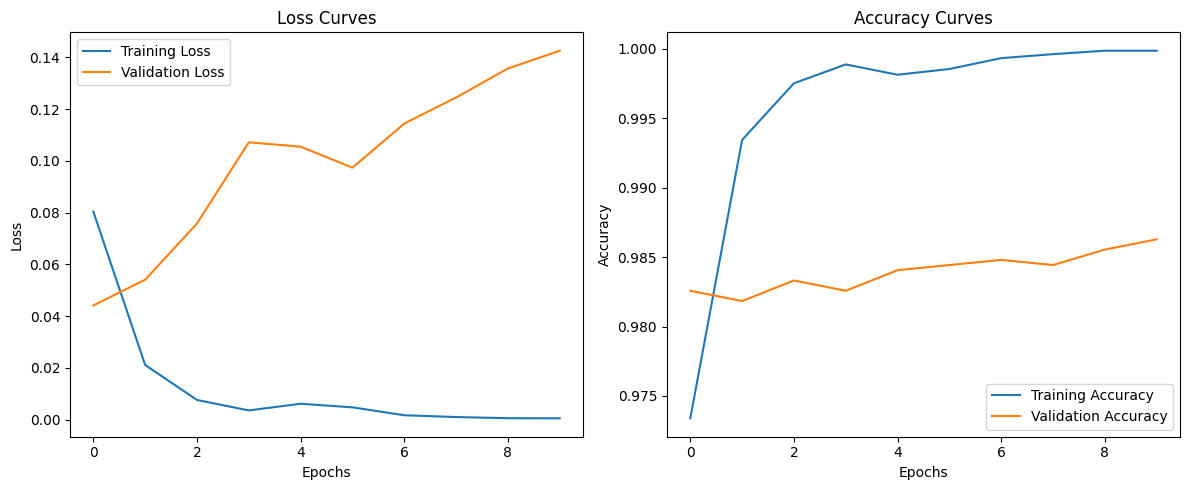

In [ ]:
# 17. Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.show()

In [ ]:
# 18. Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9862



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3309
           1       0.99      0.98      0.99      3435

    accuracy                           0.99      6744
   macro avg       0.99      0.99      0.99      6744
weighted avg       0.99      0.99      0.99      6744



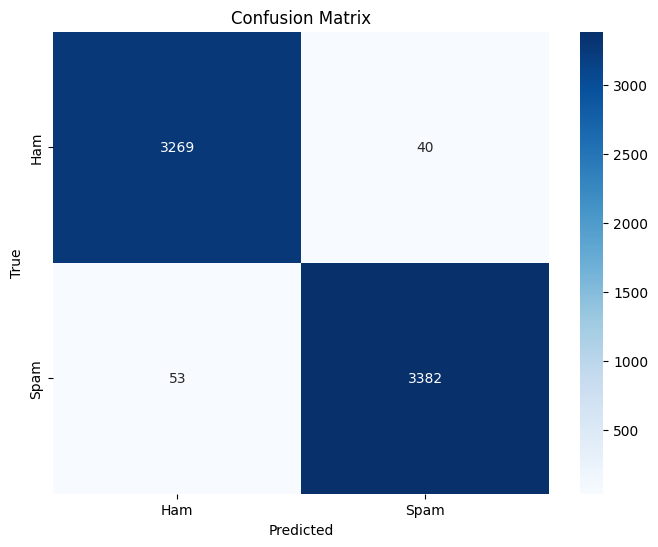

In [ ]:
# 19. Generate detailed metrics
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 20. Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'tfidf_vectorizer': tfidf_vectorizer,
    'scaler': scaler,
}, 'spam_detection_mlp.pt')
print("Model saved to 'spam_detection_mlp.pt'")

Model saved to 'spam_detection_mlp.pt'


In [ ]:
# 21. Function to predict on new emails
def predict_spam_mlp(emails, model_path='spam_detection_mlp.pt'):
    # Load the model and preprocessing components
    checkpoint = torch.load(model_path)

    # Get the vectorizer and scaler
    vectorizer = checkpoint['tfidf_vectorizer']
    scaler = checkpoint['scaler']

    # Recreate the model
    input_dim = len(vectorizer.get_feature_names_out())
    model = SpamMLP(input_dim=input_dim)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Preprocess emails
    processed_emails = [preprocess_email(email) for email in emails]

    # Transform to TF-IDF
    X = vectorizer.transform(processed_emails)
    X_scaled = scaler.transform(X)
    X_tensor = torch.FloatTensor(X_scaled.toarray())

    # Make predictions
    with torch.no_grad():
        outputs = model(X_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)

    # Prepare results
    results = []
    for i, email in enumerate(emails):
        label = "SPAM" if predictions[i].item() == 1 else "HAM"
        confidence = probabilities[i][predictions[i]].item()
        results.append({
            "email": email[:100] + "..." if len(email) > 100 else email,
            "prediction": label,
            "confidence": f"{confidence:.4f}"
        })

    return pd.DataFrame(results)

In [ ]:


# 22. Test with example emails
example_emails = [
    "Hello, just checking in about the meeting tomorrow. Let me know if you need anything from me before then.",
    "CONGRATULATIONS! You've WON $10,000,000.00 in our lottery! Send your bank details now to claim your prize!",
    "Please find attached the quarterly report for your review. Let me know if you have any questions.",
    "URGENT: Your account has been compromised. Click here immediately to verify your details and secure your account."
]

prediction_df = predict_spam_mlp(example_emails)
print("\nPredictions on new emails:")
print(prediction_df)


Predictions on new emails:
                                               email prediction confidence
0  Fuck you man! Why don't you receive my phone? ...       SPAM     1.0000
1  Hello, just checking in about the meeting tomo...        HAM     1.0000
2  CONGRATULATIONS! You've WON $10,000,000.00 in ...       SPAM     1.0000
3  Please find attached the quarterly report for ...        HAM     1.0000
4  URGENT: Your account has been compromised. Cli...       SPAM     1.0000


<ipython-input-22-579983405f8d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
